Loading images and masks...
Loaded 5108 images and 5108 masks.

Processing training data...


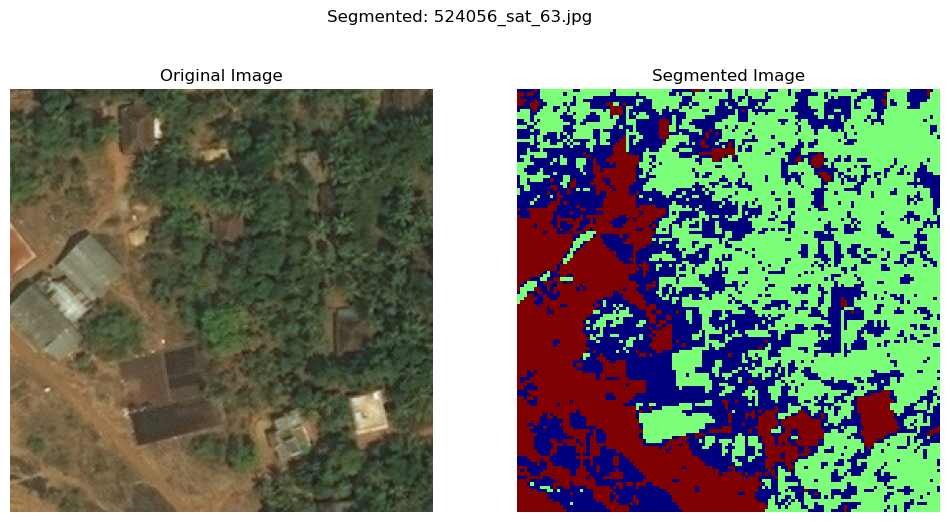

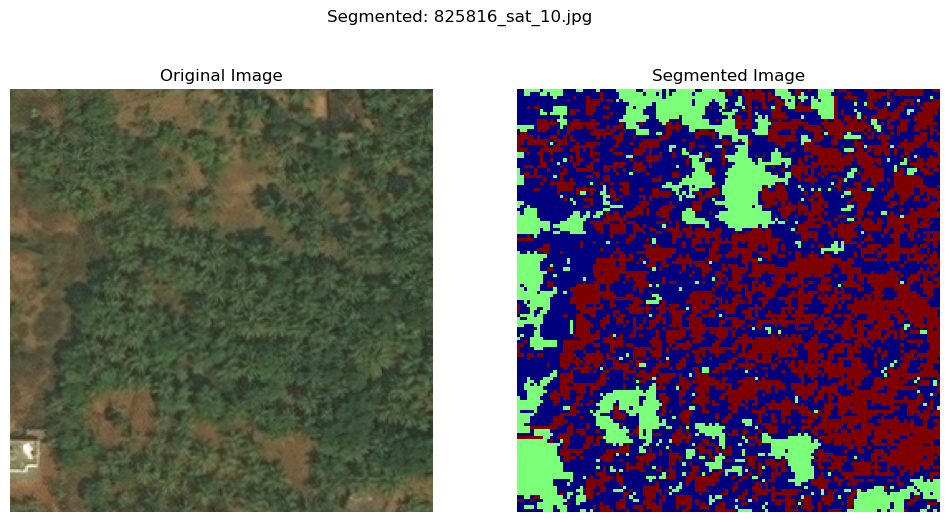

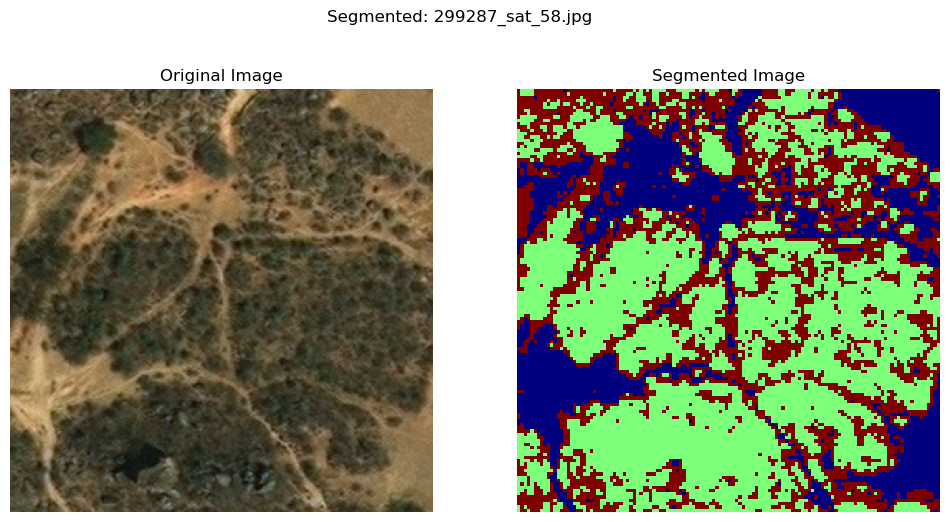

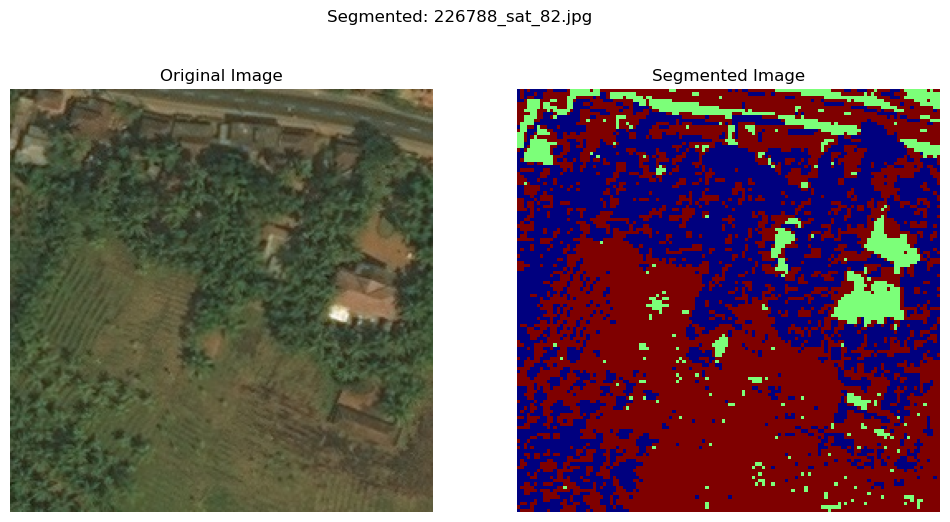

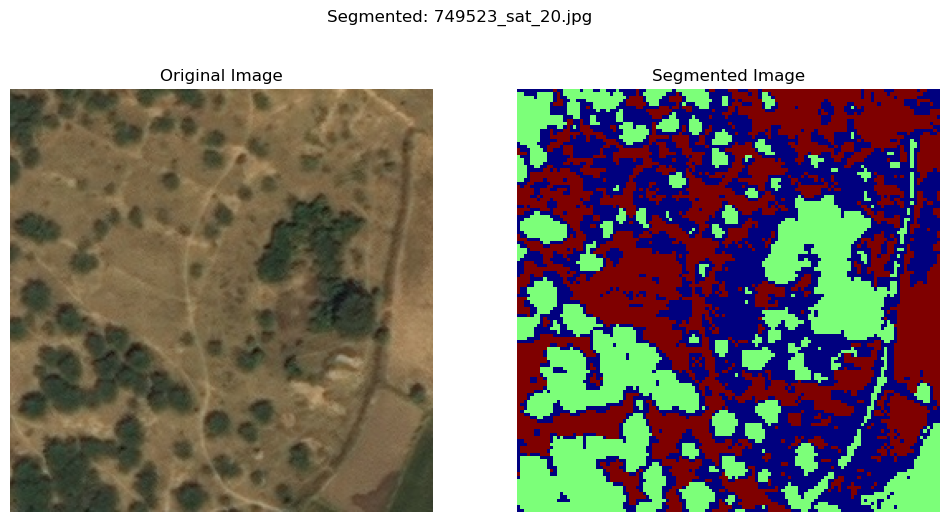


Processing testing data...


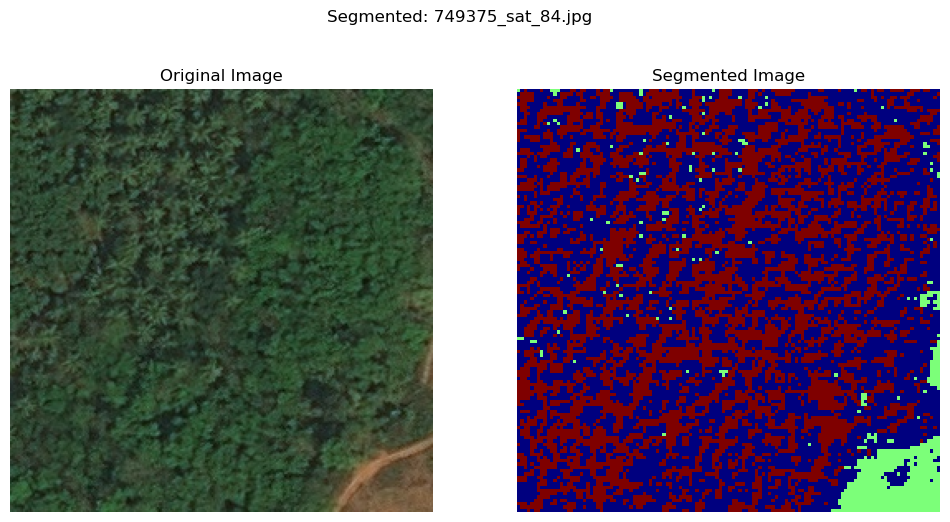

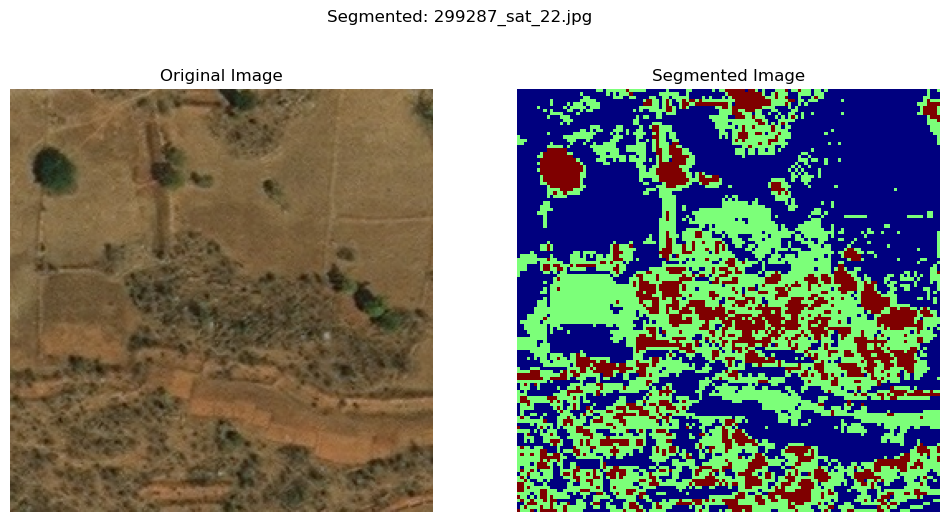

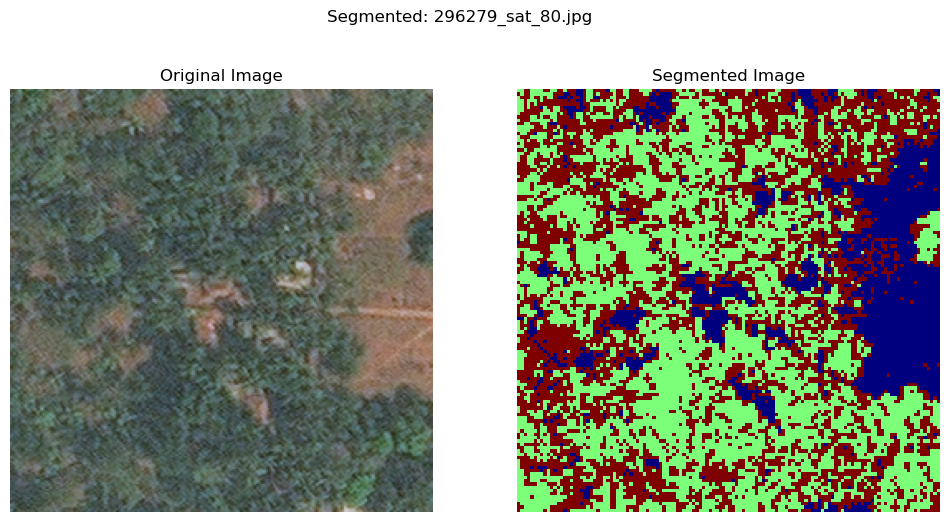

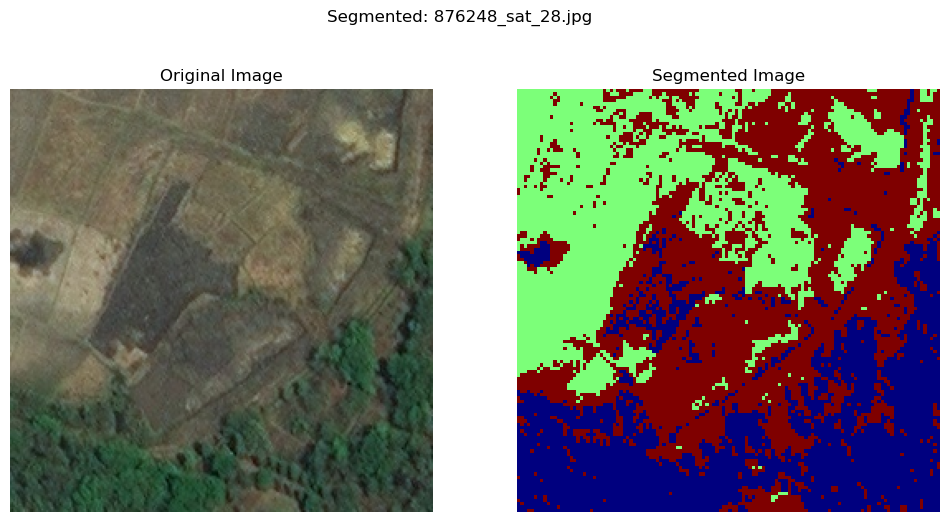

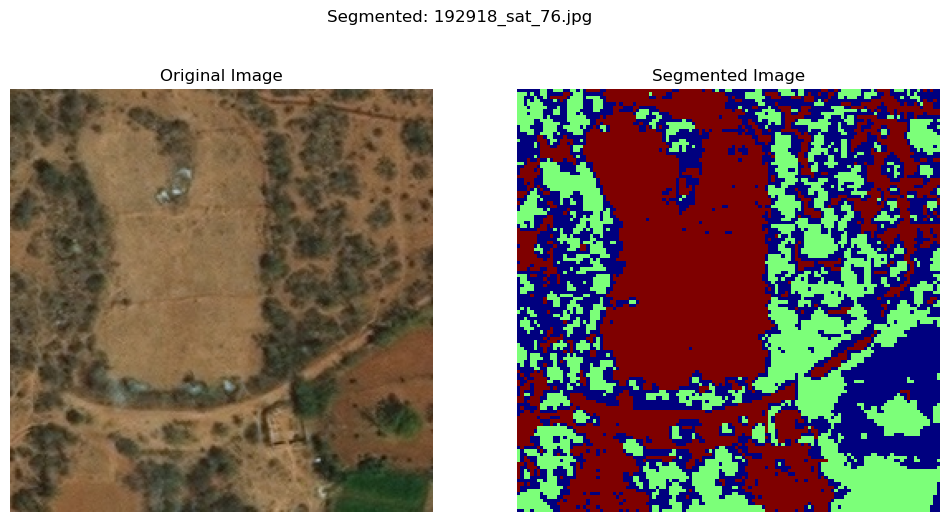

In [12]:
#FOREST IMAGE SEGMENTATION
import warnings
warnings.filterwarnings('ignore')

import os
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Function to load images and masks from folders
def load_images_and_masks(image_folder, mask_folder):
    images, masks, filenames = [], [], []
    for filename in os.listdir(image_folder):
        img_path = os.path.join(image_folder, filename)
        mask_path = os.path.join(mask_folder, filename) if mask_folder else None
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) if mask_folder and os.path.exists(mask_path) else None
        if img is not None:
            images.append(img)
            masks.append(mask)
            filenames.append(filename)
    return images, masks, filenames

# Preprocess images and masks
def preprocess_image(image, size=(128, 128)):
    resized = cv2.resize(image, size)
    normalized = resized / 255.0  # Normalize to [0, 1] range
    return normalized

def preprocess_mask(mask, size=(128, 128)):
    if mask is not None:
        resized = cv2.resize(mask, size, interpolation=cv2.INTER_NEAREST)
        return resized
    return None

# Apply K-Means clustering on an image
def apply_kmeans(image, n_clusters=3):
    pixel_values = image.reshape((-1, 3))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(pixel_values)
    labels = kmeans.labels_
    segmented_image = labels.reshape(image.shape[:2])
    return segmented_image, kmeans.cluster_centers_

# Visualize original and segmented images
def visualize_images(original, segmented, title="Original vs Segmented"):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(segmented, cmap='jet')
    plt.title("Segmented Image")
    plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Batch processing of images
def process_batches(images, filenames, masks, output_folder, n_clusters=3, visualize_limit=5):
    os.makedirs(output_folder, exist_ok=True)
    segmented_results = []
    ground_truths = []

    for img, filename, mask in zip(images, filenames, masks):
        preprocessed_img = preprocess_image(img)
        preprocessed_mask = preprocess_mask(mask)
        segmented, _ = apply_kmeans(preprocessed_img, n_clusters=n_clusters)
        
        # Save segmented image
        output_path = os.path.join(output_folder, f"segmented_{filename}")
        segmented_colorized = (segmented / segmented.max() * 255).astype(np.uint8)
        cv2.imwrite(output_path, segmented_colorized)
        
        # Store for metric calculation
        if preprocessed_mask is not None:
            segmented_results.append(segmented.flatten())
            ground_truths.append(preprocessed_mask.flatten())
        
        # Visualize limited images
        if visualize_limit > 0:
            visualize_images(img, segmented, title=f"Segmented: {filename}")
            visualize_limit -= 1
    
    return segmented_results, ground_truths


# Main script
image_folder = r"C:\Users\mamun\Downloads\Forest Segmented\Forest Segmented\images"
output_folder = r"C:\Users\mamun\Downloads\Forest Segmented\Forest Segmented\output"

# Load images and masks
print("Loading images and masks...")
images, masks, filenames = load_images_and_masks(image_folder, mask_folder)
print(f"Loaded {len(images)} images and {sum(mask is not None for mask in masks)} masks.")

# Split into training and testing sets
train_images, test_images, train_filenames, test_filenames, train_masks, test_masks = train_test_split(
    images, filenames, masks, test_size=0.2, random_state=42
)

# Process training and testing data
print("\nProcessing training data...")
train_segmented, train_ground_truths = process_batches(train_images, train_filenames, train_masks, os.path.join(output_folder, "train"), n_clusters=3)

print("\nProcessing testing data...")
test_segmented, test_ground_truths = process_batches(test_images, test_filenames, test_masks, os.path.join(output_folder, "test"), n_clusters=3)



In [10]:
import os
import numpy as np
import cv2
from sklearn.metrics import accuracy_score, f1_score, jaccard_score

# Function to load images from a folder
def load_images(folder_path):
    images = []
    filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
                filenames.append(filename)
    return images, filenames

# Function to resize segmentation output to match ground truth mask
def resize_image(image, target_shape):
    return cv2.resize(image, (target_shape[1], target_shape[0]))

# Function to calculate metrics for all images and compute overall averages
def calculate_overall_metrics(segmented_folder, ground_truth_folder):
    segmented_images, _ = load_images(segmented_folder)
    ground_truth_images, _ = load_images(ground_truth_folder)

    if len(segmented_images) != len(ground_truth_images):
        raise ValueError("Mismatch in the number of images between segmented and ground truth folders.")
    
    total_pixels = 0
    correct_pixels = 0
    f1_scores = []
    iou_scores = []

    for segmented, ground_truth in zip(segmented_images, ground_truth_images):
        # Resize segmented output to match ground truth dimensions
        resized_segmented = resize_image(segmented, ground_truth.shape)
        
        # Convert to binary masks (for water vs non-water)
        _, segmented_binary = cv2.threshold(resized_segmented, 127, 1, cv2.THRESH_BINARY)
        _, ground_truth_binary = cv2.threshold(ground_truth, 127, 1, cv2.THRESH_BINARY)
        
        # Flatten arrays for pixel-wise comparison
        y_pred_flat = segmented_binary.flatten()
        y_true_flat = ground_truth_binary.flatten()
        
        # Accumulate metrics
        total_pixels += len(y_true_flat)
        correct_pixels += np.sum(y_pred_flat == y_true_flat)
        
        f1_scores.append(f1_score(y_true_flat, y_pred_flat, average='weighted'))
        iou_scores.append(jaccard_score(y_true_flat, y_pred_flat, average='weighted'))

    # Calculate overall metrics
    overall_pixel_accuracy = correct_pixels / total_pixels
    overall_f1 = np.mean(f1_scores)
    overall_iou = np.mean(iou_scores)

    print("Overall Metrics:")
    print(f"  Pixel Accuracy: {overall_pixel_accuracy * 100:.2f}%")
    print(f"  Average F1 Score: {overall_f1:.2f}")
    print(f"  Average IoU: {overall_iou:.2f}")

# Paths to folders
segmented_folder = r"C:\Users\mamun\Downloads\Forest Segmented\Forest Segmented\output\segmented"
ground_truth_folder = r"C:\Users\mamun\Downloads\Forest Segmented\Forest Segmented\masks" 

# Run the calculation
calculate_overall_metrics(segmented_folder, ground_truth_folder)


Overall Metrics:
  Pixel Accuracy: 48.32%
  Average F1 Score: 0.54
  Average IoU: 0.40
